In [1]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt 
import random
from torchsummary import summary

import torchviz

import networkx as nx
import matplotlib.pyplot as plt

from graphviz import Digraph

import math

random.seed('Mudit')

In [2]:
def viz(inputs,model) :
    x = torch.randn(inputs)
    y = model(x)
    f = torchviz.make_dot(y , params = dict(model.named_parameters()))
    return f

In [3]:
class Node:
    count = -1
    def __init__(self,type=None) :
        Node.count += 1
        self.name = str(Node.count)
        self.type = type
        self.id = id(self)
        self.child = []  
        self.parent = []
        self.output = None
        self.input = None
        self.outputTensor = None
    def addChild(self,x):
        self.child.append(x)
    def removeChild(self,x) :
        self.child.remove(x)
    def addParent(self,x):
        self.parent.append(x)
    def removeParent(self,x) :
        self.parent.remove(x)

In [4]:
class ConvBlock(nn.Module,Node) :
    def __init__(self, in_channels, out_channels, kernel_size, activation='relu' ,stride=1, padding=0, dilation=1, groups=1, bias=True) :
        # missing bn params : eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

        super(ConvBlock,self).__init__()
        Node.__init__(self,'conv')
       
        self.c = nn.Conv2d(in_channels,out_channels,kernel_size)
        self.b = nn.BatchNorm2d(out_channels)
        
        if activation == 'relu' :
            self.a = nn.ReLU()
        elif activation == 'tanh' :
            self.a = nn.Tanh()
        #add others if you want.
    
    def forward(self,x) :
        return self.a(self.b(self.c(x)))
    
    def widenAsNext(self,in_channels):
        #when widen as child
        next_layer = self.c
        orig_channels = next_layer.in_channels
        weights = [next_layer.weight.data]
        next_layer = nn.Conv2d(in_channels,
                               next_layer.out_channels,
                               kernel_size=next_layer.kernel_size
                              )
        
        next_layer.weight.data[:,0:orig_channels] = weights[0]
        self.c = next_layer
        
        
    def widenAsCurrent(self,factor):
        #affects channels only, no effect on kernel size.
        #when widen as current node
        '''
            @inputs : 
            widening factor : 2,4

            Example :
                a1 = Conv
                a1.widen(2)
        '''     
        current_layer = self.c
        bn_current = self.b         
            
        orig_channels = current_layer.out_channels
        
        weights = [current_layer.weight.data]  
        bn_weights = [bn_current.weight.data]
        
        current_layer = nn.Conv2d(current_layer.in_channels,
                                  orig_channels*factor,
                                  kernel_size=current_layer.kernel_size,
                                  stride=current_layer.stride)       
        bn_current = nn.BatchNorm2d(current_layer.out_channels)

        current_layer.weight.data[0:orig_channels,:] = weights[0]
        bn_current.weight.data[:orig_channels] = bn_weights[0][:]

        self.c = current_layer
        self.b = bn_current

In [5]:
class MaxPool(nn.Module,Node) :
    def __init__(self, kernel_size):
        super(ConvBlock,self).__init__()
        Node.__init__(self,type='maxpool')
        
        self.m = nn.MaxPool2d(kernel_size)
        
    def forward(self, x) :
        return self.m(x)
    
    def widen(self, kernel_size) :
        self.m = nn.MaxPool2d(kernel_size)

In [6]:
class Merge(nn.Module,Node) :
    def __init__(self) :
        super(Merge,self).__init__()
        Node.__init__(self,'merge')
        
        
    def forward(self,x1,x2) :
        return torch.cat([x1,x2],1)

In [7]:
class Add (nn.Module,Node) :
    def __init__(self,) :
        super(Add,self).__init__()
        Node.__init__(self,'add')
        
        
    def forward(self,**x) :
#         assert x1.shape == x2.shape , 'Size mismatch while Adding tensors'
        ke = x.keys()
        t = x[ke[0]]
        for i in ke[1:] :
            t = t+x[i]
        return t
    
    
x = torch.randn((1,2))
y = torch.randn((1,2))
z = torch.randn((1,2))
a = Add()
d = d={'a'+str(i):x_x for i,x_x in enumerate([x,y,z])}
a(**d).shape

torch.Size([1, 2])

Using above blocks, create a graph, update that graph using applyMorph and at the end render the graph and train it.


In [8]:
class Model(nn.Module) :
    def __init__(self) :
        super(Model,self).__init__()
        
        self.c1 = ConvBlock(1,32,3)
        self.c2 = ConvBlock(32,32,3)
        self.c3 = ConvBlock(32,32,3)
        self.c4 = ConvBlock(32,32,3)
        self.fc = nn.Linear(3200,1000)
        self.fc2 = nn.Linear(1000,10)

        
    def forward(self,x) :
        out = self.c1(x)
        out1 = self.c2(out)
        out2 = self.c3(out)
        out3 = self.c4(out)
#         add = Add()
        p = [out1,out2,out3]
        d={'a'+str(i):x_x for i,x_x in enumerate(p)}
        out = a(**d)
        print out.shape
        out = out.view(-1,3200)
        out = self.fc2(self.fc(out))
        return out

In [9]:
x = torch.randn((1,1,14,14))
m = Model()
m(x)

torch.Size([1, 32, 10, 10])


tensor([[-0.5572,  0.0156, -0.5699,  0.1871, -0.0213, -0.1603, -0.2313, -0.0416,
          0.3123,  0.0310]], grad_fn=<ThAddmmBackward>)

In [10]:
from torchsummary import summary

In [11]:
summary(m,(1,14,14))

torch.Size([2, 32, 10, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 12, 12]             320
       BatchNorm2d-2           [-1, 32, 12, 12]              64
              ReLU-3           [-1, 32, 12, 12]               0
         ConvBlock-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 32, 10, 10]           9,248
       BatchNorm2d-6           [-1, 32, 10, 10]              64
              ReLU-7           [-1, 32, 10, 10]               0
         ConvBlock-8           [-1, 32, 10, 10]               0
            Conv2d-9           [-1, 32, 10, 10]           9,248
      BatchNorm2d-10           [-1, 32, 10, 10]              64
             ReLU-11           [-1, 32, 10, 10]               0
        ConvBlock-12           [-1, 32, 10, 10]               0
           Conv2d-13           [-1, 32, 10, 10]           9,248
      Batch

torch.Size([2, 32, 10, 10])


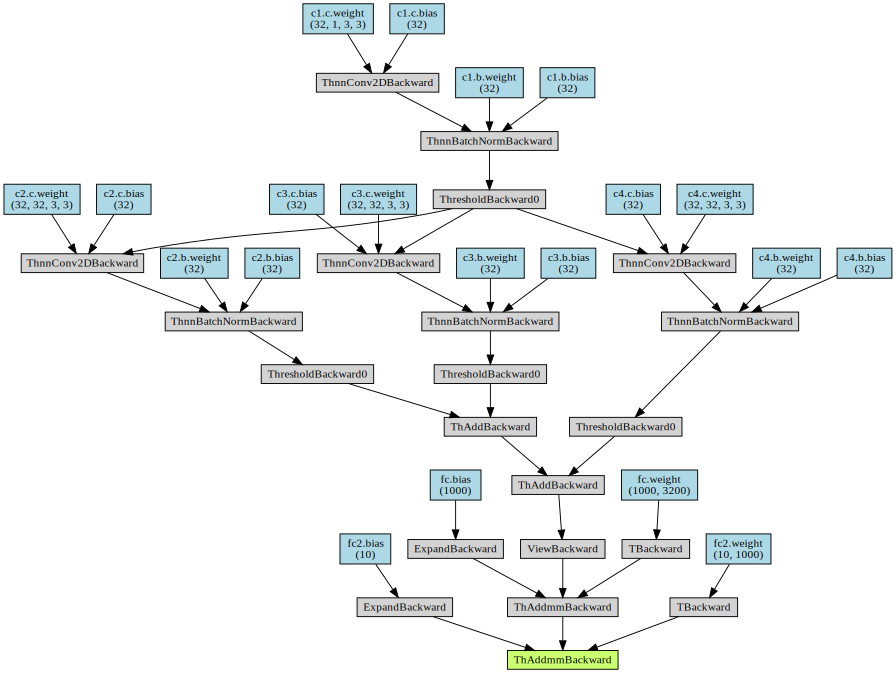

In [12]:
viz((2,1,14,14),m)

In [13]:
class Graph :    
    '''
        Implements TopSort & IsCyclic
    ''' 
    
    
    def __init__(self):
        pass

    
    def isCyclicUtil(self,v, visited, recStack): 

        visited[v] = True
        recStack[v] = True

        for neighbour in self.nodes[v].child: 
            if visited[neighbour] == False: 
                if self.isCyclicUtil(neighbour, visited, recStack) == True: 
                    return True
            elif recStack[neighbour] == True: 
                return True

        recStack[v] = False
        return False

    def isCyclic(self): 
        visited = {}
        recStack = {}
        for i in self.nodes :
            visited[i]=False
            recStack[i]=False

        for node in self.nodes: 
            if visited[node] == False: 
                if self.isCyclicUtil(node,visited,recStack) == True: 
                    return True
        return False
    
    def makeEdgeAndCheckIsCyclic(self,v1,v2):
        '''
            Edge test from v1 to v2
        '''
        #makeEdge
        self.nodes[v1].child.append(v2)
        #Check
        cycle = self.isCyclic()
        #return to normal
        self.nodes[v1].child.remove(v2)
        
        return cycle

    
    def topologicalSortUtil(self,v,visited,stack): 
        visited[v] = True
        for i in self.nodes[v].child: 
            if visited[i] == False: 
                self.topologicalSortUtil(i,visited,stack) 

        stack.insert(0,v) 

    def topologicalSort(self,name=False): 
        visited = {}
        for i in self.nodes :
            visited[i]=False

        stack =[] 

        for i in self.nodes: 
            if visited[i] == False: 
                self.topologicalSortUtil(i,visited,stack) 
        
        if name :
            for i in stack :
                print self.nodes[i].name,' ',
        else :
            return stack
        
    def plotGraph(self):
        G = nx.DiGraph()
        
        edges = []
        cmap = {'conv':'red','add':'blue','merge':'green','maxpool':'yellow'}
        for nod in self.nodes :
            for ch in self.nodes[nod].child :
#                 edges.append((self.nodes[nod].name,self.nodes[ch].name))
                G.add_edge(self.nodes[nod].name,self.nodes[ch].name)

#         G.add_edges_from(edges)
        colormap = []
        for n in G :
            colormap.append(cmap[self.name2type[n]])
        pos = nx.spring_layout(G,k=(5/math.sqrt(G.order())),iterations=30)
        nx.draw_networkx_nodes(G, pos, node_color=colormap,node_size = 200,linewidths=0)
        nx.draw_networkx_labels(G, pos)
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(),arrowstyle='->')
        plt.show()
        return G
        
    def plotGraph2(self,filename='unix.gv') :
        u = Digraph('unix', filename=filename)
        cmap = {'conv':'red','add':'blue','merge':'green','maxpool':'yellow'}
        
        for nod in self.nodes :
            na = self.name2type[self.nodes[nod].name]+self.nodes[nod].name
            u.node(na,color=cmap[self.name2type[self.nodes[nod].name]])
        
        for nod in self.nodes :
            for ch in self.nodes[nod].child :
                na = self.name2type[self.nodes[nod].name]+self.nodes[nod].name
                nb = self.name2type[self.nodes[ch].name]+self.nodes[ch].name
                u.edge(na,nb)
        
        u.view()


In [14]:
class NASGraph(nn.Module,Graph) :
    def __init__(self,input) :
        #input is 3d always!!!!
        super(NASGraph,self).__init__()
#         Graph.__init__(self)
        
        
        self.name2type = {}
#         name2type has been replaced by type attribute of Node
#         begin changing code to incorporate node.type instead of self.name2type
        
        self.nodes = {}
        self.nodesByType = {'conv':[],
                           'maxpool':[],
                           'add':[],
                           'merge':[]}
#         self.convNodes = []
        self.begin = None
#         self.alloperations = ['conv','deepen','skip']
#         self.skipoperations = ['add','merge']
        self.alloperations = ['conv','deepen']
        
        self.nns = None
        
        
        self.order = None
#         x = torch.randn((2,gr.nodes[gr.begin].c.in_channels,128,128))
        self.samplex = torch.randn((2,input[0],input[1],input[2]))
        
    def addNode(self,**args):
        '''
            SAME AS APPLYMORPH
            
            for Conv :
            block = conv
            in_channels, out_channels,kernel_size
            
            for MaxPool
            block = 'maxpool'
            kernel_size
            
            for Concat -- not implemented
            block = 'concat'
            
            for Merge
            block = 'merge
            
            for Add 
            block = 'add'
            
            
            @returns : created node
        '''
        
        if(args['block'] == 'conv') :
            node = ConvBlock(args['in_channels'],args['out_channels'],args['kernel_size'])
            self.nodesByType['conv'].append(node.id)
#             self.convNodes.append(node.id)
            self.name2type[node.name] = 'conv'
            
        elif(args['block'] == 'maxpool') :
            node = MaxPool(args['kernel_size'])
            self.name2type[node.name] = 'maxpool'
            
        elif(args['block'] == 'add') :
            node = Add()
            self.name2type[node.name] = 'add'
            
        elif(args['block'] == 'merge') :
            node = Merge()
            self.name2type[node.name] = 'merge'
#         elif(args['block'] == 'concat') :
#             node = Concat()
        
        try :
            self.nodes[node.id] = node
        except : 
            raise "Hashmap ERR"
            
        if len(self.nodes) == 1 :
            self.begin = node.id
        
        return node.id
    
    def addInGraph(self,log=False,prevnodes=None,nextnodes=None,**args) :
        '''
            @prevnodes = list of node.ids which are parents of this conv node
        '''
        n = self.addNode(**args)
        
        if prevnodes is not None :
            for pnodes in prevnodes :
                assert type(pnodes)==type(1) , 'Check input Type addInGraph'
                self.nodes[pnodes].addChild(n)
                self.nodes[n].addParent(pnodes)
                
        if nextnodes is not None :
            for nnodes in nextnodes :
                assert type(nnodes)==type(1) , 'Check input Type addInGraph'
                self.nodes[n].addChild(nnodes)
                self.nodes[nnodes].addParent(n)
        if log :
            print 'Added node : ', self.nodes[n].name
        return n

    def showAllNodes(self):
        cnt = 0
        for ir in self.nodes.keys() :
            print 'Node Number : ',cnt
            print 'Node ID : ',gr.nodes[ir].name
            print 'Node Children :'
            for ch in gr.nodes[ir].child :
                print self.nodes[ch].name,
            print ''
            print gr.nodes[ir]
            print '-'*30
            cnt+=1
    
    def createModel(self,runTopSort=True):
        allNodes = []
        for ir in self.nodes.keys() :
            allNodes.append(self.nodes[ir])

        self.nns = nn.Sequential(*allNodes)
        
        if runTopSort :
            self.order = self.topologicalSort()
        
        
    def forward(self,x) :
         return self.f_forward(x)
    
    def f_forward(self,x) :
        ## INCOMPLETE FUNCTION ... MANAGE WHEN MULTI PARENTS SUPPLY INP TO CHILD
        ## INF INPUTS TO ADD NODE , FOR MERGE 2 , FOR OTHERS 1
        if c == len(self.order) :
            return

        curr = self.order[c]

        if len(self.nodes[curr].parent) != 0 :
            self.nodes[curr].outputTensor = self.nodes[curr](trial).shape
        else :
            self.nodes[curr].input = trial.shape
            self.nodes[curr].output = self.nodes[curr](trial).shape


        if log :
            print '-'*20
        self.compatCheck(c=c+1,log=log)
        
     
    def getoperation(self) :
        op = self.alloperations[random.randint(0,len(self.alloperations)-1)]
#         if op == 'skip' :
#             op = self.skipoperations[random.randint(0,len(self.skipoperations)-1)]
        return op
    
    def findTwoVerticesForConv(self,log=False) :
        
        # ------------------------------ PLEASE OPTIMIZE ------------------------------
        posParent = -1
        posChild = -1
        notFound = True
        
        while notFound :
            #add limit to attempts to prevent inf loop

            def fn(x):
                return self.nodes[x].type
            
            idxordered = [self.order[i] for i,val in enumerate(map(fn,self.order)) if val=='conv']
            
            a = random.choice(range(0,len(idxordered)))
            
            #now newindxordered must contain only those conv which are of same 
            # output D as a child of self.nodes[a] if a child exist.
            
#             if len(self.nodes[idxordered[a]].child) > 0 :
            # output of self.nodes[a] must match with output of all parents of next node
            
            # supports finding nodes which can later be converted to add 
            # SUPPORT for 'Merge' and Maxpool req.
            
            outP = self.nodes[idxordered[a]].output
            
            b = -1
            
            if a != len(idxordered)-1 :
                newidxordered = self.findConvWithDim(dimen=outP,dType='input',afterNode=idxordered[a])
                newidxordered = [newidxordered[i] for i,val in enumerate(map(fn,newidxordered)) if val=='conv']
                b = random.choice(newidxordered)
            
#             if a != len(idxordered)-1 :
#                 newidxor = idxordered[a+1:]
#                 newidxordered = []
#                 for eachnode in newidxor :
#                     if self.nodes[eachnode].input == outP :
#                         newidxordered.append(eachnode)
                    
                    
#                     parent = self.nodes[eachnode].parent
#                     outFlag = False
#                     for eachpar in parent :
#                         if self.nodes[eachpar].output != self.nodes[idxordered[a]].output :
#                             outFlag = True
#                     if not outFlag :
#                         newidxordered.append(eachnode)
#                   b = random.choice(newidxordered)
                
            
            a = idxordered[a]
            
            if log : 
                print 'A/B :',a,b
            posParent = a
            posChild = -1
            if b != -1 :
                posChild = b

            #directed from posParent to posChild
            # 1. Check for direct Child
            # 2. makeEdgeandCheckForCycle
            if posChild != -1:
                if posChild in self.nodes[posParent].child :
                    continue  # cont in loop
                #make and test
                if self.makeEdgeAndCheckIsCyclic(posParent,posChild) :
                    continue
                else :
                    prevnodes = [posParent]
                    nextnodes = [posChild]
                    notFound = False 
                    
#                     print self.nodes[posParent].name,self.nodes[posChild].name    
                    return prevnodes, nextnodes
            else :
                prevnodes = [posParent]
                nextnodes = []
                notFound = False
#                 print self.nodes[posParent].name,-1
                return prevnodes, nextnodes
        
            #------ TODO ------
            #prev must always be smaller than next
            #need to check this somehow......else there'll be a cycle BAD BAD BAD BAD BAD BAD
            #NEED TO TAKE CARE OF CYCLES -- NO CYCLES ALLOWED
            
            
    def findTwoForAdd(self):
        pass
    
    #for deepen
    def convWithSingleConvParent(self) :
        reqpairs = []
        for eachconv in self.nodesByType['conv'] :
            #if this node has only one child and its child has only this parent.
            child = self.nodes[eachconv].child
            if len(child) == 1 :
                parent = self.nodes[child[0]].parent
                if len(parent) == 1:
                    reqpairs.append((eachconv,child[0]))
        return reqpairs
    
    def applyMorph(self,log=False) :
        #update output shapes for all nodes.
        self.order = self.topologicalSort()
#         self.compatCheck()
        
        op = self.getoperation()
        #op = 'conv'
        if log :
            print 'OPERATION CALLED : ',op
        layer = {'block' : op}
        if op == 'conv' :
            #choose kernel
            kernel_size = 3
            if random.random() > 0.5 :
                kernel_size = 5
                
                
            #choose position
            prevnodes, nextnodes = self.findTwoVerticesForConv()
            print 'Nodes Selected :', self.nodes[prevnodes[0]].name ,
            
            try :
                print self.nodes[nextnodes[0]].name ,
            except :
                print [] , 
                
            #describe factors
            layer['in_channels'] = self.nodes[prevnodes[0]].c.out_channels #out of prev one
            if len(nextnodes) != 0 : 
                layer['out_channels'] = self.nodes[nextnodes[0]].c.in_channels #in of next one
            else :
                layer['out_channels'] = 16 #DEFAULT
                
                
            layer['kernel_size'] = kernel_size
            
            if log :
                print 'Between : ', prevnodes,' ', nextnodes
            n = self.addInGraph(prevnodes=prevnodes,nextnodes=nextnodes,**layer)
            print ' Added :',self.nodes[n].name
            
            
        elif op == 'deepen' :
            # use widenAsCurrent for this node (changes output)
            # use widenAsNext for all its child nodes -> C (changes input)
            # use widenAsCurrent for all the parents of C except this node itself and so on... (changes output)
            # perform above two recursively ...
            
            #choose factor
            factor = 2
            if random.random() > 0.5 :
                factor = 4
            
            #works only for conv->conv one to one nodes.
            pairs = self.convWithSingleConvParent()
            #if nothing found.
            if len(pairs) == 0 :
                if log :
                    print 'FAILED DEEPEN'
                return
            
            idx = random.choice(range(0,len(pairs)))
            prevN,nextN = pairs[idx]
            
            if log :
                print 'Between : ', self.nodes[prevN].name,' ', self.nodes[nextN].name
            
            self.nodes[prevN].widenAsCurrent(factor)
            self.nodes[nextN].widenAsNext(self.nodes[prevN].c.out_channels)
            
        elif op == 'add' :
            # select two nodes say p,q where p<q topologically 
            # Apply add node here 
            # child of this add node = {all the child nodes of q, some child nodes of q}
            pass
            
        elif op == 'concat' :
            # 1. use maxpool at some point say P .. after convs p1,p2... after P we get half the image size, but with 
            # same channels <--  then concat at image dimensions
            #
            # 2. use merge to merge at channel <-- add block=merge
            pass
        
        
#         self.applyNecessaryAddNodes()
#         self.removeUnecessaryAddNodes()
        
        
    def applyNecessaryAddNodes(self,log=False) :
        #create a new Add node 
        #make all parents of this node and parents of add node
        #make this node child of add node
        
        
        for no in self.nodesByType['conv']:
            
            
            if len(self.nodes[no].parent)>1 :
                prevnodes = self.nodes[no].parent
                
                #check parents compatible for add operation.
                flag = True
                chkoutput = self.nodes[prevnodes[0]].output
                for ipx in prevnodes[1:] :
                    if self.nodes[ipx].output != chkoutput :
                        if log :
                            print 'Cannot Apply Add'
                        flag = False
                        
                if flag :
                    
                    nextnodes = [no]

                    for pa in prevnodes :
                        self.nodes[pa].removeChild(no)

                    n = self.addInGraph(prevnodes=prevnodes,nextnodes=nextnodes,**{'block':'add'})
                    self.nodes[no].parent = [n]
                
                #remove no as child from its parents list.

    def removeUnecessaryAddNodes(self) :
        #for each add node 
        # if all the children are add nodes
        # take parent node of this main add node 
        # remove this add node
        # create proper links 
#         for no in self.nodes :
#             if self.name2type[self.nodes[no].name] == 'add' :
#                 for ch in self.nodes[no].child :
#                     if self.name2type[self.nodes[ch].name] == 'add' :
        pass



    def compatCheck(self,c=0,log=False) :
        # modify compatCheck for merge operation
        # current implemetation only caters to add where all parents must have the same output shape
        
        x = self.samplex
        if c == len(self.order) :
            return

        curr = self.order[c]

        if log :
            print 'Type :',self.nodes[curr].type , ' Name :',self.nodes[curr].name
        
        if log and self.nodes[curr].type=='conv':
            print 'NODE :',self.nodes[curr].name , ' IN_C :', self.nodes[curr].c.in_channels ,' OUT_C :', self.nodes[curr].c.out_channels 

        if len(self.nodes[curr].parent) != 0 :
            outshape = self.nodes[gr.nodes[curr].parent[0]].output
            for par in self.nodes[curr].parent[1:] :
                if log :
                    print 'OutShape Comparison :',outshape,self.nodes[par].output
                assert (self.nodes[par].output==outshape) ,'CompatCheckErorr'
                outshape = self.nodes[par].output

            trial = torch.randn(outshape)
            self.nodes[curr].input = trial.shape
            
            if self.nodes[curr].type is 'add' :
                #done to simulate add node -- otherwise inp = out for add
                d = {'a'+str(i):x_x for i,x_x in enumerate([trial,trial])}
                self.nodes[curr].output = self.nodes[curr](**d).shape
            
            else :
                self.nodes[curr].output = self.nodes[curr](trial).shape
        else :
            if log :
                print 'No parents...'
            trial = x
            self.nodes[curr].input = trial.shape
            
            if self.nodes[curr].type is 'add' :
            #done to simulate add node -- otherwise inp = out for add
                d = {'a'+str(i):x_x for i,x_x in enumerate([trial,trial])}
                self.nodes[curr].output = self.nodes[curr](**d).shape
            else :
                self.nodes[curr].output = self.nodes[curr](trial).shape


        if log :
            print '-'*20
        self.compatCheck(c=c+1,log=log)
        
        
    def findConvWithDim(self,dimen,dType='output',forceTop = False,afterNode=-1) :
        '''
            dimen = dimen to be searched for
            dType = 'output/input' dimen 

            Run compatCheck before calling this.
        '''
        
        if forceTop :
            self.order = self.topologicalSort()
            self.compatCheck()
        
        order = self.order
        
        if afterNode != -1 :
            print 'Found'
            pos = order.index(afterNode)
            order = order[pos:]
        
        def fn(x):
            return self.name2type[gr.nodes[x].name]

        convOrdered = [order[i] for i,val in enumerate(map(fn,order)) if val=='conv']
        result = []
        for eachconv in convOrdered :
            if dType == 'input' :
                if self.nodes[eachconv].input == dimen :
                    result.append(eachconv)
            elif dType == 'output' :
                if self.nodes[eachconv].output == dimen :
                    result.append(eachconv)
        return result
                    

In [15]:
random.seed('Mudit4')
Node.count = -1
gr = NASGraph(([1, 128, 128]))
p = {'block':'conv','in_channels':1,'out_channels':16,'kernel_size':3}
gr.addInGraph(**p)
for _ in range(30):
    gr.applyMorph(log=False)
#     gr.plotGraph2(filename=str(_)+'.gv')
print 'TopSort:',
gr.order = gr.topologicalSort()
gr.topologicalSort(name=True)
gr.createModel()
x = torch.randn((2,gr.nodes[gr.begin].c.in_channels,128,128))

# gr.compatCheck(log=True)

print '\n','-'*20
for each in gr.nodes :
    print gr.nodes[each].name , gr.nodes[each].input, gr.nodes[each].output


Nodes Selected : 0 []  Added : 1
Found
Nodes Selected : 1 []  Added : 2
Nodes Selected : 2 []  Added : 3
Nodes Selected : 3 []  Added : 4
Found
Nodes Selected : 0 3  Added : 5
Found
Nodes Selected : 1 4  Added : 6
Nodes Selected : 4 []  Added : 7
Found
Nodes Selected : 5 7  Added : 8
Found
Found
Nodes Selected : 7 []  Added : 9
Found
Found
Nodes Selected : 2 7  Added : 10
Found
Found
Found
Found
Nodes Selected : 10 3  Added : 11
Found
Found
Nodes Selected : 10 4  Added : 12
Found
Found
Nodes Selected : 1 3  Added : 13
Found
Nodes Selected : 12 7  Added : 14
TopSort: 0   5   8   1   13   6   2   10   12   14   11   3   4   7   9   
--------------------
1 None None
5 None None
3 None None
12 None None
11 None None
13 None None
4 None None
8 None None
0 None None
2 None None
9 None None
7 None None
6 None None
10 None None
14 None None


In [16]:
gr.showAllNodes()

Node Number :  0
Node ID :  1
Node Children :
2 6 13 
ConvBlock(
  (c): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a): ReLU()
)
------------------------------
Node Number :  1
Node ID :  5
Node Children :
3 8 
ConvBlock(
  (c): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
  (b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a): ReLU()
)
------------------------------
Node Number :  2
Node ID :  3
Node Children :
4 
ConvBlock(
  (c): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a): ReLU()
)
------------------------------
Node Number :  3
Node ID :  12
Node Children :
4 14 
ConvBlock(
  (c): Conv2d(1024, 16, kernel_size=(3, 3), stride=(1, 1))
  (b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a): ReLU()
)
--------------

In [18]:
gr.plotGraph2()
gr.topologicalSort(name=True)
# print '\n','-'*20
# for each in gr.nodes :
#     print gr.nodes[each].name , gr.nodes[each].input, gr.nodes[each].output
# print '\n','-'*20
gr.compatCheck(log=True)

0   5   8   1   13   6   2   10   12   14   11   3   4   7   9   Type : conv  Name : 0
NODE : 0  IN_C : 1  OUT_C : 64
No parents...
--------------------
Type : conv  Name : 5
NODE : 5  IN_C : 64  OUT_C : 16
--------------------
Type : conv  Name : 8
NODE : 8  IN_C : 16  OUT_C : 1024
--------------------
Type : conv  Name : 1
NODE : 1  IN_C : 64  OUT_C : 64
--------------------
Type : conv  Name : 13
NODE : 13  IN_C : 64  OUT_C : 16
--------------------
Type : conv  Name : 6
NODE : 6  IN_C : 64  OUT_C : 16
--------------------
Type : conv  Name : 2
NODE : 2  IN_C : 64  OUT_C : 16
--------------------
Type : conv  Name : 10
NODE : 10  IN_C : 16  OUT_C : 1024
--------------------
Type : conv  Name : 12
NODE : 12  IN_C : 1024  OUT_C : 16
--------------------
Type : conv  Name : 14
NODE : 14  IN_C : 16  OUT_C : 1024
--------------------
Type : conv  Name : 11
NODE : 11  IN_C : 1024  OUT_C : 16
--------------------
Type : conv  Name : 3
NODE : 3  IN_C : 16  OUT_C : 16
OutShape Comparison : t

AssertionError: CompatCheckErorr

In [ ]:
gr.applyNecessaryAddNodes()

In [ ]:
gr.plotGraph2()

In [ ]:
x = torch.randn((2,8,128,128))
p = nn.Conv2d(8,16,3)
q = nn.Conv2d(16,16,3)
print p(x).shape , q(p(x)).shape

In [ ]:
x = torch.randn((2,8,128,128))
p = nn.Conv2d(8,32,3)
q = nn.Conv2d(32,16,3)
print p(x).shape , q(p(x)).shape

In [ ]:
for attempts in range(20) :
    
    try :
        Node.count = -1
        gr = NASGraph(([8, 128, 128]))
        p = {'block':'conv','in_channels':8,'out_channels':16,'kernel_size':3}
        gr.addInGraph(**p)
        for _ in range(50):
            gr.applyMorph()
        print 'TopSort:',
        gr.order = gr.topologicalSort()
        gr.topologicalSort(name=True)
        gr.createModel()
        x = torch.randn((2,gr.nodes[gr.begin].c.in_channels,128,128))
        
        
        gr.topologicalSort(name=True)
        compatCheck(0,gr,log=True)
        for each in gr.nodes :
            print gr.nodes[each].name , gr.nodes[each].input, gr.nodes[each].output
        gr.plotGraph2()
        
        print 'PASSED'
        break
    except :
        pass

In [ ]:
gr.topologicalSort(name=True)
compatCheck(0,gr,log=True)
for each in gr.nodes :
    print gr.nodes[each].name , gr.nodes[each].input, gr.nodes[each].output
gr.plotGraph2()

In [ ]:
gr.compatCheck(log=False)
for each in gr.nodes :
    print gr.nodes[each].name , gr.nodes[each].input, gr.nodes[each].output
    
gr.plotGraph2()
resout = gr.findConvWithDim(dimen=torch.Size([2, 16, 126, 126]),dType='input',forceTop=True)
for r in resout :
    print gr.nodes[r].name
resout = gr.findConvWithDim(dimen=torch.Size([2, 16, 126, 126]),dType='output',forceTop=False)
for r in resout :
    print gr.nodes[r].name

In [ ]:
# gr.applyNecessaryAddNodes()
# gr.plotGraph2()